## Takeaway from this homework
* This homework mainly teaches different techniques to minimize the loss.
* In exercise 1, we performed hyperparameter tuning to search for better context size, embedding size, # neurons in the hidden layer, training batch size.
* In exercise 2, we learned that we should initialize the weights to have near uniform predicted probabilities. The starting loss is much lower than random initialization. This can be achieved by using normal distribution of zero mean and near zero std.
* In exercise 3, we modifed the network to have weight decay and regularization.

# Setup

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [5]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-08-25 21:57:34--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-08-25 21:57:34 (7.85 MB/s) - ‘names.txt’ saved [228145/228145]



In [6]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

## Indexing

In [7]:
def stoi(c):
  """Maps 1 character to its index"""
  ord1 = 0 if c == '.' else ord(c) - ord('a') + 1
  if not (0 <= ord1 < 27 and 0 <= ord1 <= 27):
    raise ValueError("Invalid characters")
  return ord1

def itos(v):
  """Maps an index to 1 character"""
  if not (0 <= v < 27):
    raise ValueError("Invalid index number")
  return '.' if v == 0 else chr(ord('a') + v - 1)

print("itos(1)=", itos(1))
print("stoi('a')=", stoi('a'))

itos(1)= a
stoi('a')= 1


## Core ML

In [122]:
import random
from collections import OrderedDict

split_random_seed = 42 # for reproducibility
network_random_seed = 2147483647 # for reproducibility

def _build_dataset(words, block_size=3):
  """
  Builds the dataset based on block size.

  Parameters:
    words (list[str]): list of words

  Returns:
    (X, Y):  mappings from context of block size to the next character.
  """

  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi(ch)
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  return torch.tensor(X), torch.tensor(Y)

def split_dataset(words, block_size=3, train_ratio=0.8, dev_ratio=0.1):
  """Splits dataset into train, dev, test"""

  random.seed(split_random_seed)
  random.shuffle(words)
  n1 = int(train_ratio*len(words))
  n2 = int((train_ratio+dev_ratio)*len(words))
  Xtr, Ytr = _build_dataset(words[:n1], block_size)
  Xdev, Ydev = _build_dataset(words[n1:n2], block_size)
  Xte, Yte = _build_dataset(words[n2:], block_size)

  return dict({
    'train': {'xs': Xtr, 'ys': Ytr},
    'dev': {'xs': Xdev, 'ys': Ydev},
    'test': {'xs': Xte, 'ys': Yte}
  })

def tuneable_network(block_size=3, embedding_size=10, neurons1=200):
  g = torch.Generator().manual_seed(network_random_seed)
  C = torch.randn((27, embedding_size), generator=g)
  W1 = torch.randn((block_size * embedding_size, neurons1), generator=g)
  b1 = torch.randn(neurons1, generator=g)
  W2 = torch.randn((neurons1, 27), generator=g)
  b2 = torch.randn(27, generator=g)
  parameters = OrderedDict({
      "C": C,
      "W1": W1,
      "b1": b1,
      "W2": W2,
      "b2": b2,
  })
  for p in parameters.values():
    p.requires_grad = True
  return parameters

def train(Xtr, Ytr, params, batch_size=32, passes=200000):
  """Trains the neural network."""

  # Neural network parameters
  C, W1, b1, W2, b2 = params['C'], params['W1'], params['b1'], params['W2'], params['b2']
  block_size = Xtr.shape[1]
  embedding_size = C.shape[1]
  sample_size = Xtr.shape[0]

  # Trains and records losses
  lossi = []
  stepi = []
  for i in range(passes):

    # minibatch construct
    ix = torch.randint(0, sample_size, (batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, embedding_size)
    h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # (batch_size, block_size)
    logits = h @ W2 + b2 # (batch_size, output_size)
    loss = F.cross_entropy(logits, Ytr[ix])

    # backward pass
    for p in params.values():
      p.grad = None
    loss.backward()

    # update with weight decaly after 100,000 passes
    lr = 0.1 if i < 100000 else 0.01
    for p in params.values():
      p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
  return stepi, lossi

def eval_loss(X, Y, params):
  """Evaluates loss."""

  C, W1, b1, W2, b2 = params['C'], params['W1'], params['b1'], params['W2'], params['b2']
  block_size, embedding_size = X.shape[1], C.shape[1]
  emb = C[X] # (sample_size, block_size, embedding_size)
  h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # (sample_size, block_size)
  logits = h @ W2 + b2 # (sample_size, output_size)
  return F.cross_entropy(logits, Y).item()

# Exercise 1
* Tune the hyperparameters of the training to beat my best validation loss of 2.2

In [123]:
def execute_process(block_size, embedding_size, neurons1, batch_size, passes=200000):
  print("Split data...")
  data = split_dataset(words, block_size)
  print("Done!")

  print("Initialize network...")
  params = tuneable_network(block_size, embedding_size, neurons1)
  print("Done!")

  print("Training...")
  stepi, lossi = train(data['train']['xs'], data['train']['ys'], params, batch_size, passes)
  print("Done!")

  return stepi, lossi

## Karpathy benchmark

In [111]:
def execute_karpathy_process():
  execute_process(3, 10, 100, 32)

Split data...
Done!
Initialize network...
Done!
Training...
Done!
Eval loss...
train loss is 2.1139450073242188
dev loss is 2.166984796524048
test loss is 2.178025245666504
Training plot...


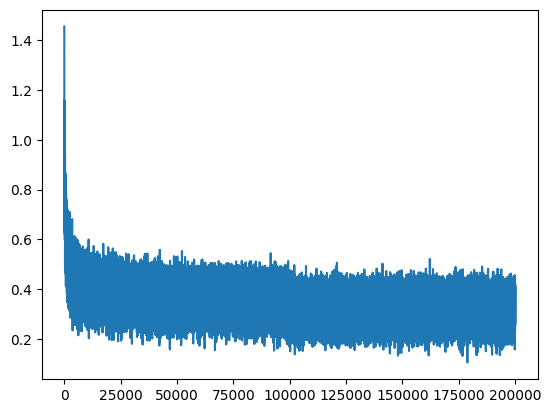

In [49]:
execute_karpathy_process()

## Beat Karpathy benchmark

* Tune the block size
* Tune the embedding size
* Tune the number of neuron in the hidden layers
* Tune the batch size


### Hyperparameters

In [106]:
block_sizes = [3, 5, 7, 9]
embedding_sizes = [10, 15, 20, 25, 30]
neurons1s = [10, 25, 50, 100, 150, 200, 250, 300]
batch_sizes = [16, 64, 256]
len(block_sizes) * len(embedding_sizes) * len(neurons1s) * len(batch_sizes)

480

In [107]:
def tune(block_size, embedding_size, neurons1, batch_size, passes):
  data = split_dataset(words, block_size)
  params = tuneable_network(block_size, embedding_size, neurons1)
  stepi, lossi = train(data['train']['xs'], data['train']['ys'], params, batch_size, passes)
  return eval_loss(data['dev']['xs'], data['dev']['ys'], params)

In [108]:
# Comments out because this takes a long time to tune.
# best_hyperparameters = None
# best_loss = None
# for block_size in block_sizes:
#   for embedding_size in embedding_sizes:
#     for neurons1 in neurons1s:
#       for batch_size in batch_sizes:
#         dev_loss = tune(block_size, embedding_size, neurons1, batch_size, 50000, verbose=False)
#         if best_loss is None or dev_loss < best_loss:
#           best_hyperparameters = [block_size, embedding_size, neurons1, batch_size]
#           best_loss = dev_loss
#           print("New best found=", best_hyperparameters, ", with best lost=", best_loss)
# block_size, embedding_size, neurons1, batch_size = best_hyperparameters

In [109]:
block_size = 3
embedding_size = 15
neurons1 = 100
batch_size = 256

### Solution

In [124]:
def execute_my_process():
  execute_process(3, 15, 100, 256)

Split data...
Done!
Initialize network...
Done!
Training...
Done!
Eval loss...
train loss is 2.1192378997802734
dev loss is 2.168278694152832
test loss is 2.163639545440674
Training plot...


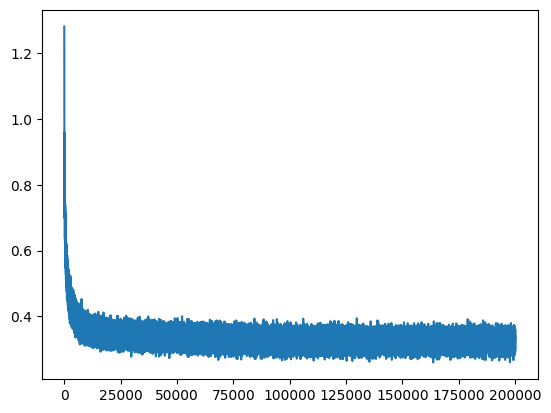

In [103]:
execute_my_process()

# Exercise 2
*  I was not careful with the intialization of the network in this video. (1) What is the loss you'd get if the predicted probabilities at initialization were perfectly uniform? What loss do we achieve? (2) Can you tune the initialization to get a starting loss that is much more similar to (1)?

**Answer:**
* 1) The starting loss with uniform probabilities is 3.29 (compared to random initialization of 26) and we achieve 2.17.
* 2) Yes, we can sample from normal distribution of 0 mean and very small std like 0.001.

## Karpathy's Uniform Probabilities Loss

In [117]:
data = split_dataset(words)

def tuneable_network(block_size=3, embedding_size=10, neurons1=200):
  g = torch.Generator().manual_seed(network_random_seed)
  C = torch.randn((27, embedding_size), generator=g)
  W1 = torch.randn((block_size * embedding_size, neurons1), generator=g)
  b1 = torch.randn(neurons1, generator=g)
  W2 = torch.zeros((neurons1, 27)) # We zeros out everything so the softmax probabilities are uniform
  b2 = torch.zeros(27)
  parameters = OrderedDict({
      "C": C,
      "W1": W1,
      "b1": b1,
      "W2": W2,
      "b2": b2,
  })
  for p in parameters.values():
    p.requires_grad = True
  return parameters

uniform_params = tuneable_network()
initial_loss = eval_loss(data['train']['xs'], data['train']['ys'], uniform_params)

print("The loss is", initial_loss)

The loss is 3.29583740234375


## Tune initialized weights to yield starting loss approximately equal to uniform probabilities loss

In [125]:
def tuneable_network(block_size=3, embedding_size=10, neurons1=200):
  g = torch.Generator().manual_seed(network_random_seed)
  C = torch.randn((27, embedding_size), generator=g)
  W1 = torch.randn((block_size * embedding_size, neurons1), generator=g)
  b1 = torch.randn(neurons1, generator=g)
  W2 = torch.normal(0, 1e-3, (neurons1, 27))
  b2 = torch.zeros(27)
  parameters = OrderedDict({
      "C": C,
      "W1": W1,
      "b1": b1,
      "W2": W2,
      "b2": b2,
  })
  for p in parameters.values():
    p.requires_grad = True
  return parameters

Split data...
Done!
Initialize network...
Done!
Training...
Done!
Eval loss...
train loss is 2.110740900039673
dev loss is 2.1652653217315674
test loss is 2.1535086631774902
Training plot...


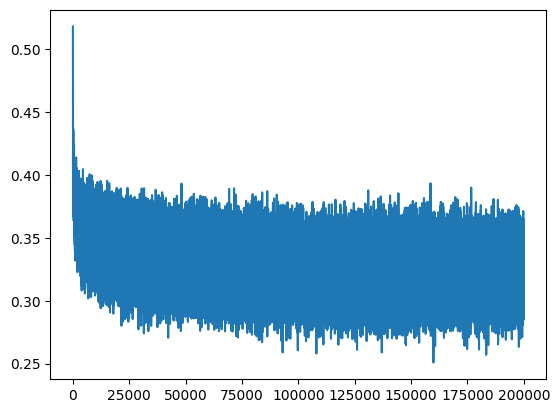

In [120]:
execute_my_process()

# Exercise 3
* Read the Bengio et al 2003 paper (link above), implement and try any idea from the paper. Did it work?

**Answer:**
* Weight decay: Initial weight of 0.1, and decreases according to schedule lr / (1 + current_pass * decrease_factor). Let decrease_factor = 1e-8.
* Add regularization.
* There are many more techniques but I'll just do the above 2.

In [128]:
def train(Xtr, Ytr, params, batch_size=32, passes=200000):
  """Trains the neural network."""

  # Neural network parameters
  C, W1, b1, W2, b2 = params['C'], params['W1'], params['b1'], params['W2'], params['b2']
  block_size = Xtr.shape[1]
  embedding_size = C.shape[1]
  sample_size = Xtr.shape[0]

  # Trains and records losses
  lossi = []
  stepi = []
  for i in range(passes):
    print(i)
    # minibatch construct
    ix = torch.randint(0, sample_size, (batch_size,))

    # forward pass
    emb = C[Xtr[ix]] # (batch_size, block_size, embedding_size)
    h = torch.tanh(emb.view(-1, embedding_size * block_size) @ W1 + b1) # (batch_size, block_size)
    logits = h @ W2 + b2 # (batch_size, output_size)
    loss = F.cross_entropy(logits, Ytr[ix])

    # Add L2 regularization
    l2_reg = torch.tensor(0.)
    for p in params.values():
        l2_reg += torch.norm(p, 2).pow(2)
    loss += 1 * l2_reg

    # backward pass
    for p in params.values():
      p.grad = None
    loss.backward()

    lr = 0.1 / (1 + i * 1e-8) # weight decay
    for p in params.values():
      p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())
  return stepi, lossi